# Clustering Presentation _ Instacart _  : FOUR IN ONE THE BEST

## Contents

1. 방향성 및 목표 설정

2. 데이터 병합 및 전처리

3. EDA

4. Clustering(Dendrogram)을 통한 변수 재설정

5. 최종 Train & Test data set

6. 평가 및 예측 (LightGBM 모델 활용)

## 1. 방향성 및 목표 설정

- 소비자별로 상품과 기간을 나타내는 변수들과의 연관성을 입체적으로 분석
- 군집화를 통해 변수 재설정한 후 LightGBM 모델을 활용한 소비자별 상품 예측 

## 2. 데이터 병합 및 전처리

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from functools import partial
color = sns.color_palette() 
import warnings

warnings.filterwarnings('ignore')

products = pd.read_csv("products.csv")
departments = pd.read_csv("departments.csv")
aisles = pd.read_csv("aisles.csv")
order_products__train = pd.read_csv("order_products__train.csv")
order_products__prior = pd.read_csv("order_products__prior.csv")
orders = pd.read_csv("orders.csv")

### 1) 데이터(Aisles, Departments와 Products) 병합

In [4]:
goods = pd.merge(left=pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')
goods.product_name = goods.product_name.str.replace(' ', '_').str.lower() 
goods.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,chocolate_sandwich_cookies,61,19,snacks,cookies cakes
1,2,all-seasons_salt,104,13,pantry,spices seasonings
2,3,robust_golden_unsweetened_oolong_tea,94,7,beverages,tea
3,4,smart_ones_classic_favorites_mini_rigatoni_wit...,38,1,frozen,frozen meals
4,5,green_chile_anytime_sauce,5,13,pantry,marinades meat preparation


#### order 시트와 order_products__train 시트의 병합 (order id로)

In [5]:
order_detail = pd.merge(right=orders, left=order_products__train, how='inner', on='order_id')
order_detail.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,112108,train,4,4,10,9.0
1,1,11109,2,1,112108,train,4,4,10,9.0
2,1,10246,3,0,112108,train,4,4,10,9.0
3,1,49683,4,0,112108,train,4,4,10,9.0
4,1,43633,5,1,112108,train,4,4,10,9.0


#### order와 order_products 시트의 병합으로 분류용 Dataset 완성

In [7]:
dataset = pd.merge(left=goods, right=order_detail, how='left', on='product_id').sort_values(['days_since_prior_order'], ascending=[True])
dataset.head()

,product_id,product_name,aisle_id,department_id,department,aisle,order_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
729673,26364,"kefir_cultured_milk_smoothie,_whole_milk,_subl...",120,16,dairy eggs,yogurt,1502119.0,9.0,1.0,137937.0,train,8.0,0.0,21.0,0.0
201996,8174,organic_navel_orange,24,4,produce,fresh fruits,202617.0,3.0,1.0,194267.0,train,13.0,1.0,15.0,0.0
34908,1559,cherry_pomegranate_greek_yogurt,120,16,dairy eggs,yogurt,3214043.0,1.0,1.0,39507.0,train,10.0,0.0,9.0,0.0
744803,26925,organic_pink_lady_(cripps)_apple,100,21,missing,missing,1011158.0,2.0,1.0,96935.0,train,72.0,6.0,20.0,0.0
34901,1559,cherry_pomegranate_greek_yogurt,120,16,dairy eggs,yogurt,3130338.0,7.0,1.0,169698.0,train,12.0,5.0,1.0,0.0


### 2) 데이터 전처리

#### 구매이력이 없는 상품들 제거

In [10]:
for col in orders.columns.values:
    if len(orders[orders[col].isnull()][col]) > 0:
        print ('{}: {}'.format(col, len(orders[orders[col].isnull()][col])))
        
for col in order_products__train.columns.values:
    if len(order_products__train[order_products__train[col].isnull()][col]) > 0:
        print ('{}: {}'.format(col, len(order_products__train[order_products__train[col].isnull()][col])))
        
for col in departments.columns.values:
    if len(departments[departments[col].isnull()][col]) > 0:
        print ('{}: {}'.format(col, len(departments[departments[col].isnull()][col])))
        
for col in aisles.columns.values:
    if len(aisles[aisles[col].isnull()][col]) > 0:
        print ('{}: {}'.format(col, len(aisles[aisles[col].isnull()][col])))
        
for col in products.columns.values:
    if len(products[products[col].isnull()][col]) > 0:
        print ('{}: {}'.format(col, len(products[products[col].isnull()][col])))

In [9]:
orders['days_since_prior_order'] = orders['days_since_prior_order'].replace(np.nan, -1, regex=True)

In [17]:
groupdd = goods.groupby(["product_id","department", "aisle"])["product_id"].aggregate({'Total_products': 'count'}).reset_index()

In [29]:
unordered = goods[goods.product_id.isin(list(set(goods.product_id) - set(groupdd.product_id)))]
print('구매이력이 없는 Product의 수: {}/{}'.format(unordered.shape[0], len(goods)))
unordered.head()

구매이력이 없는 Product의 수: 0/49688


,product_id,product_name,aisle_id,department_id,department,aisle


#### eval_set column 삭제

In [31]:
orders = orders.drop(['eval_set'], axis=1)

## 3. EDA (Exploratory Data Analysis)

### 1) 기간별

#### 일주일 중 가장 주문량이 많은 날

In [33]:
order_week = orders.groupby("order_id")["order_dow"].aggregate("sum").reset_index()
order_week = order_week.order_dow.value_counts()
ordersday = orders[["order_dow"]].replace({0:"Sunday",1:"Monday",2:"Tuesday",3:"Wednesday",4:"Thursday",5:"Friday",6:"Saturday"})

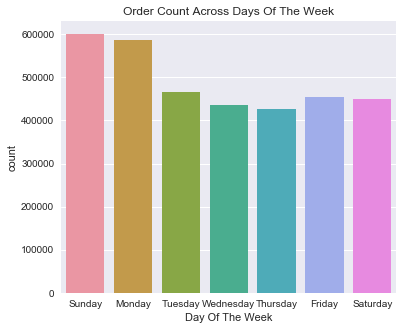

In [34]:
f, ax = plt.subplots(figsize=(6, 5))
sns.countplot(data=ordersday,x="order_dow",ax=ax,order=["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"])
ax.set(xlabel='Day Of The Week',title="Order Count Across Days Of The Week")
plt.show()

#### 몇 시에 가장 주문량이 많은가?

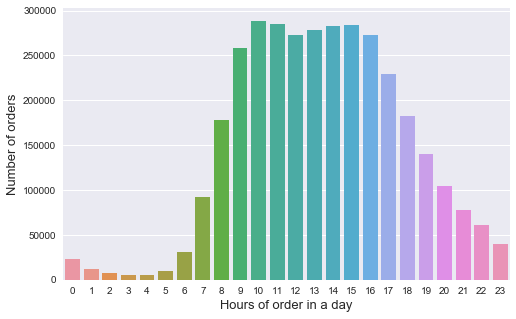

In [35]:
orders_per_hour = orders.order_hour_of_day.value_counts()
sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(8, 5))
sns.barplot(orders_per_hour.index, orders_per_hour.values)
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Hours of order in a day', fontsize=13)
plt.show()

#### 구매 후 재주문하는 Term은 얼마??

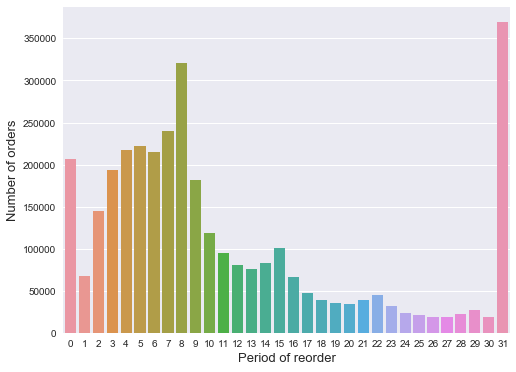

In [36]:
grouped = orders.groupby("order_id")["days_since_prior_order"].aggregate("sum").reset_index()
grouped = grouped.days_since_prior_order.value_counts()

from matplotlib.ticker import FormatStrFormatter
f, ax = plt.subplots(figsize=(8, 6))
sns.barplot(grouped.index, grouped.values)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Period of reorder', fontsize=13)
plt.show()

### 2) 상품별

#### 최다 주문 상품 Best10

In [39]:
most_ordered = order_products__train["product_id"].value_counts().to_frame()
most_ordered["count"] = most_ordered.product_id
most_ordered["product_id"] = most_ordered.index
mergedData = pd.merge(most_ordered,products, how="right", on="product_id").sort_values(by="count", ascending=False)

In [40]:
mergedData[:10]

,product_id,count,product_name,aisle_id,department_id
0,24852,18726.0,Banana,24,4
1,13176,15480.0,Bag of Organic Bananas,24,4
2,21137,10894.0,Organic Strawberries,24,4
3,21903,9784.0,Organic Baby Spinach,123,4
4,47626,8135.0,Large Lemon,24,4
5,47766,7409.0,Organic Avocado,24,4
6,47209,7293.0,Organic Hass Avocado,24,4
7,16797,6494.0,Strawberries,24,4
8,26209,6033.0,Limes,24,4
9,27966,5546.0,Organic Raspberries,123,4


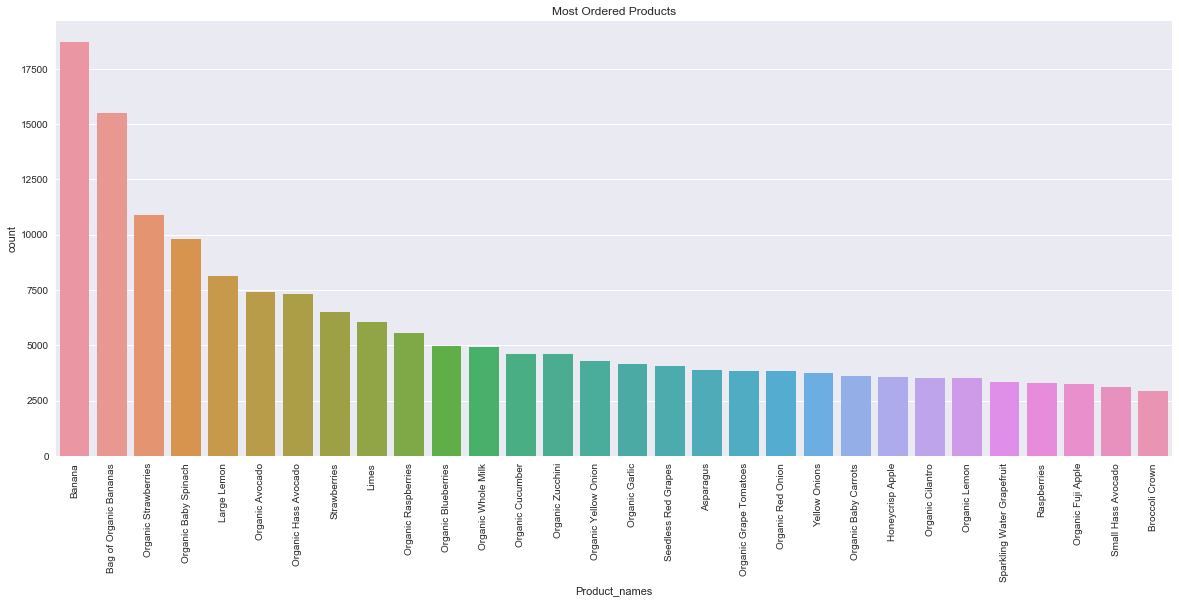

In [41]:
fig,ax = plt.subplots()
fig.set_size_inches(20,8)
sns.barplot(data=mergedData.head(30),x="product_name",y="count",ax=ax,orient="v")
ax.set(xlabel='Product_names',ylabel="count",title="Most Ordered Products")
plt.xticks(rotation=90)
plt.show()

#### Department별 상품 수

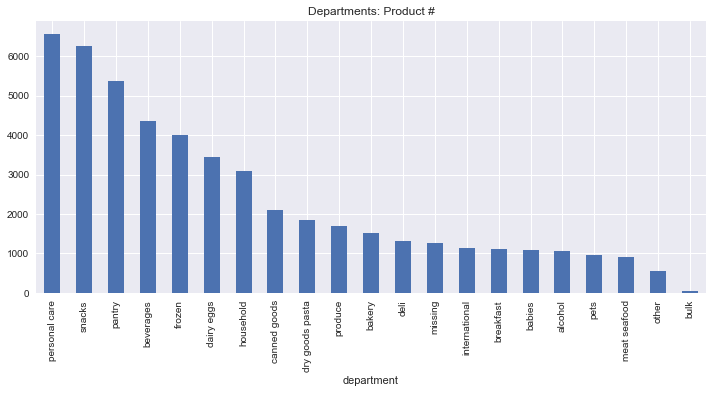

In [50]:
plt.figure(figsize=(12, 5))
goods.groupby(['department']).count()['product_id'].copy()\
.sort_values(ascending=False).plot(kind='bar', 
                                   #figsize=(12, 5), 
                                   title='Departments: Product #')
plt.show()

#### 한 번 주문시 주문량

In [51]:
order_at_once = orders.groupby('user_id')['order_id'].apply(lambda x: len(x.unique())).reset_index()
print('Average number of orders per customer: ', order_at_once.order_id.mean())

Average number of orders per customer:  16.5903670548


In [52]:
order_at_once = order_at_once.groupby('order_id').aggregate('count')

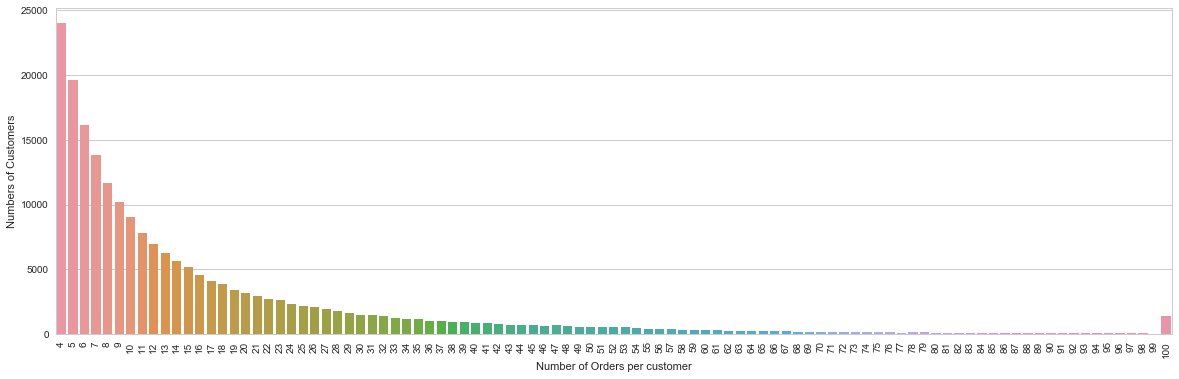

In [53]:
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(20, 6))
sns.barplot(order_at_once.index, order_at_once.user_id)
plt.ylabel('Numbers of Customers')
plt.xlabel('Number of Orders per customer')
plt.xticks(rotation='vertical')
plt.show()

#### 상품 재주문율 Top10

In [55]:
grouped4 = order_products__train.groupby("product_id")["reordered"].aggregate({'reorder_sum': sum,'reorder_total': 'count'}).reset_index()
grouped4['reorder_probability'] = grouped4['reorder_sum'] / grouped4['reorder_total']
grouped4 = pd.merge(grouped4, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped4 = grouped4[grouped4.reorder_total > 75].sort_values(['reorder_probability'], ascending=False)[:10]
grouped4

,product_id,reorder_sum,reorder_total,reorder_probability,product_name
1374,1729,86,92,0.934783,2% Lactose Free Milk
16529,20940,336,368,0.913043,Organic Low Fat Milk
16610,21038,72,81,0.888889,Organic Spelt Tortillas
19574,24852,16557,18726,0.884172,Banana
100,117,106,120,0.883333,Petit Suisse Fruit
30852,39180,426,483,0.881988,Organic Lowfat 1% Milk
9723,12384,237,269,0.881041,Organic Lactose Free 1% Lowfat Milk
18956,24024,405,461,0.878525,1% Lowfat Milk
28917,36717,71,81,0.876543,Double Fiber Bread
30462,38689,1056,1206,0.875622,Organic Reduced Fat Milk


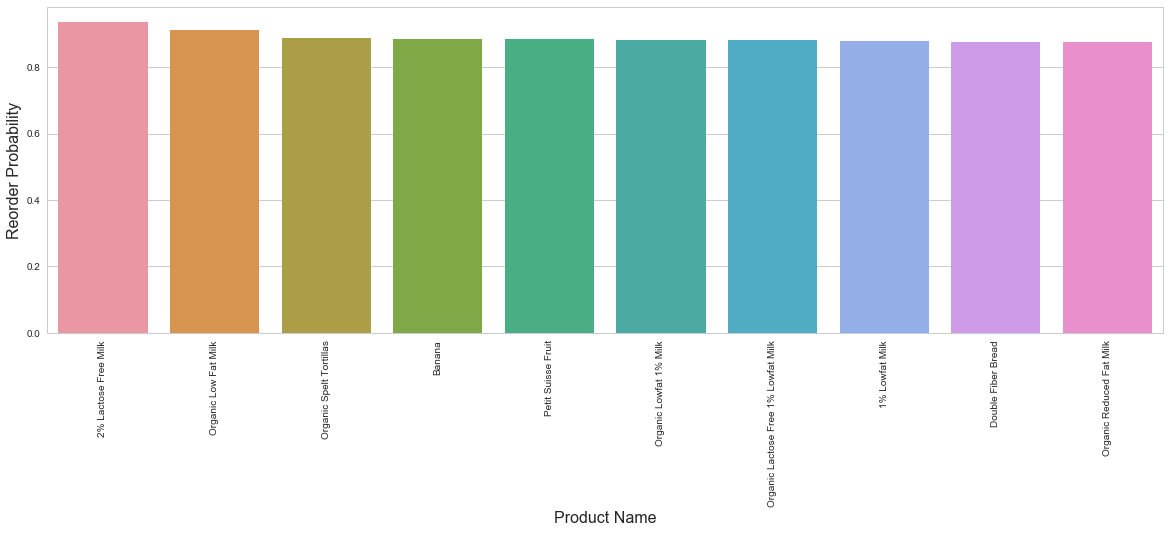

In [58]:
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(20, 6))
sns.barplot(grouped4.product_name, grouped4.reorder_probability)
plt.ylabel('Reorder Probability', fontsize=16)
plt.xlabel('Product Name', fontsize=16)
plt.xticks(rotation='vertical')
plt.show()

In [60]:
def toReadable(v):
    value = round(v,2) if isinstance(v, float) else v

    if value < 1000:
        return str(value)
    elif value<1000000:
        return str(round(value/1000,1))+'K'
    elif value>=1000000:
        return str(round(value/1000000,1))+'M'
    return value

In [61]:
orders = pd.read_csv('orders.csv') # raw_order_ds
order_products__train = pd.read_csv('order_products__train.csv') 

products = pd.read_csv('products.csv') # product_ds

order_product_cnt_ds = order_products__train.groupby('order_id').count()[['product_id']]
order_product_cnt_ds.columns = ['product_cnt']

## join product count 
order_ds = orders.merge(order_product_cnt_ds, left_on='order_id', right_index=True)

In [62]:
index2day = "Sun Mon Tue Wed Thu Fri Sat".split()

In [63]:
def drawWeekHour(ds, values,  aggfunc=len, title=None, figsize=(18,5) , cmap=None):
    weekhour_ds = ds.pivot_table(index='order_dow', columns='order_hour_of_day', values=values, aggfunc=aggfunc).fillna(0)
    weekhour_ds.index =  [index2day[index] for index in weekhour_ds.index]
    sns.set(style="whitegrid", palette="colorblind", font_scale=1, rc={'font.family':'NanumGothic'} )

    plt.figure(figsize=figsize)
    f = sns.heatmap(weekhour_ds, annot=True, fmt="1.1f", linewidths=.5, cmap=cmap) 
    plt.xlabel("Hour")
    plt.ylabel("Day of Week")
    if title:
        plt.title(title, fontsize=15)

### 추가사항

#### 1. 주문 횟수가 많아질수록 재주문까지 걸리는 기간이 짧아질까?

In [66]:
print("평균 재주문 기간(주기)은 {} 일입니당.".format(round(order_ds.days_since_prior_order.mean(),2)))

평균 재주문 기간(주기)은 17.05 일입니당.


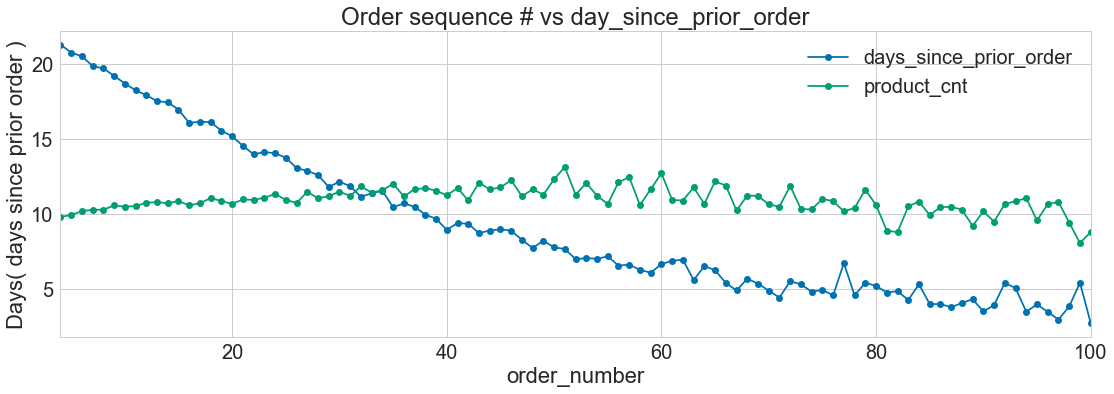

In [68]:
sns.set(style="whitegrid", palette="colorblind", font_scale=2)

order_ds.groupby('order_number').agg({'days_since_prior_order':np.mean, 'product_cnt':np.mean})\
    .plot(figsize=(16,6), title="Order sequence # vs day_since_prior_order", marker='o' )
plt.ylabel('Days( days since prior order )')
plt.tight_layout()
plt.show()

##### Insights & Followup

- 주문 횟수가 많아질수록 (충성고객일 확률이 높을수록) 재주문까지 걸리는 일 수가 짧아지는 경향을 보임

In [69]:
drawWeekHour(order_ds, values='days_since_prior_order', title="prior orders", aggfunc=lambda x: np.mean(x), cmap='YlGn')

#### 2. 재주문 기간이 짧을수록 재주문 비율이 높을까?

In [70]:
merge_order_products__train = order_products__train.merge(order_ds, on='order_id' )

In [71]:
reordered_since_days_ds = merge_order_products__train.groupby(['days_since_prior_order','reordered']).agg({'product_id':len})
reordered_since_days_ds = reordered_since_days_ds.reset_index().pivot(index='days_since_prior_order', columns='reordered', values='product_id')
reordered_since_days_ds['reorder_rate'] = reordered_since_days_ds[1] /reordered_since_days_ds.sum(axis=1)
avg_reordered_rate = round(reordered_since_days_ds[1].sum() / reordered_since_days_ds[[0,1]].sum().sum(),2) # 재주문율

In [72]:
avg_reordered_rate

0.59999999999999998

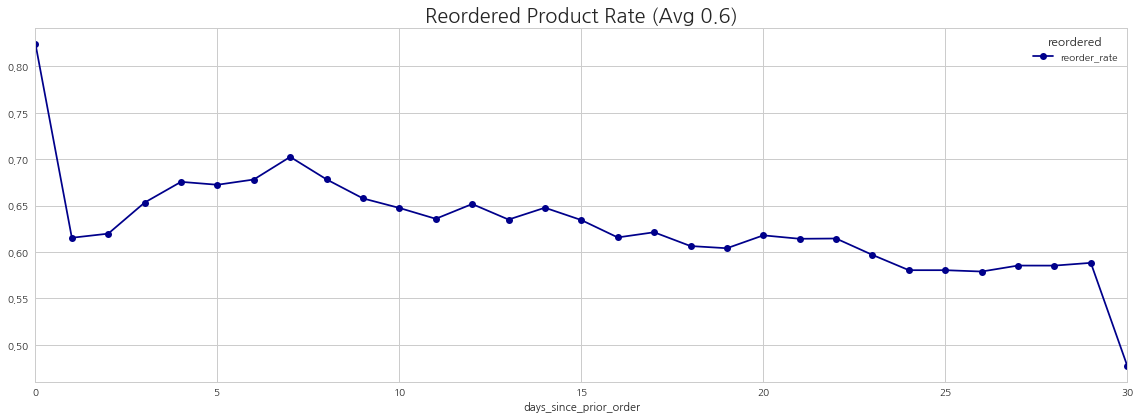

In [74]:
reordered_since_days_ds[['reorder_rate']].plot(kind='line', marker='o',figsize=(16,6), color="darkblue")
plt.title("Reordered Product Rate (Avg {})".format(avg_reordered_rate), fontsize=20)
plt.tight_layout()
plt.show()

##### Insights & Followup

- 완만하게 상관관계를 보이고 있다. 전주문과의 주기가 길어질수록 리오더율이 완만하게 떨어짐
- 다만, 이것이 하나의 Feature로 결정력을 가질 정도의 유의한 차이라고 보이지는 않음
- 상식적으로 주기적으로 구매해야 하는 유제품, 채소등의 구매주기가 일주일 정도기 때문에 상대적으로 높게 보이는 수준

#### 3. 많이 주문한 고객일수록 재구매 비율이 높을까?

In [75]:
reordered_order_num_ds = merge_order_products__train.groupby(['order_number','reordered']).agg({'product_id':len})
reordered_order_num_ds = reordered_order_num_ds.reset_index().pivot(index='order_number', columns='reordered', values='product_id')
reordered_order_num_ds['reorder_rate'] = reordered_order_num_ds[1] / reordered_order_num_ds.sum(axis = 1)
avg_reordered_rate = round(reordered_order_num_ds[1].sum() / reordered_order_num_ds[[0, 1]].sum().sum(), 2)
reordered_order_num_ds.fillna(0, inplace=True)

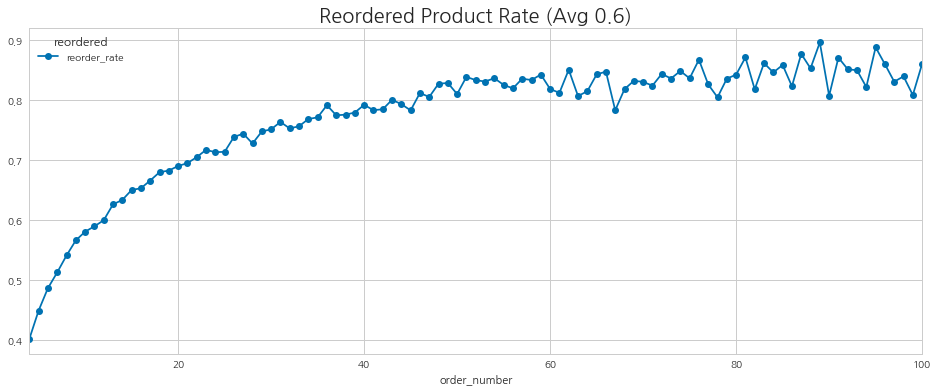

In [76]:
reordered_order_num_ds[['reorder_rate']].plot(kind='line', marker='o',figsize=(16,6))
plt.title("Reordered Product Rate (Avg {})".format(avg_reordered_rate), fontsize=20)
plt.show()

##### Insights & Followup

- 주문 횟수가 40회 이상인 고객의 재구매 상품의 비율은 80% 이상

#### 4. 어떤 상품이 재구매 비율이 높을까? 

In [77]:
product_reorder_ds = merge_order_products__train.groupby(['product_id']).agg({'order_id':len,
                                                                         'reordered':lambda x: len(x[x>0]),
                                                                         'user_id':lambda x: len(x.unique())})

In [78]:
convert_colnames = {'user_id':'unique_users','reordered':'reorder' , 'order_id':'total_order'}
product_reorder_ds.columns = [convert_colnames[col] for col in product_reorder_ds.columns]

In [79]:
product_reorder_ds['reorder_rate'] = round(product_reorder_ds.reorder / product_reorder_ds.total_order,2)
product_reorder_ds['orders_per_user'] = round(product_reorder_ds.total_order / product_reorder_ds.unique_users,2)
product_reorder_ds = product_reorder_ds.merge(products, left_index=True, right_on='product_id')

In [80]:
rankrank =product_reorder_ds[product_reorder_ds.total_order>1000].sort_values('reorder_rate', ascending=False)\
        [['product_name','total_order', 'reorder_rate', 'aisle_id']][:20]

rankrank.head(20)

,product_name,total_order,reorder_rate,aisle_id
24851,Banana,18726,0.88,24
38688,Organic Reduced Fat Milk,1206,0.88,84
13175,Bag of Organic Bananas,15480,0.86,24
27844,Organic Whole Milk,4908,0.85,84
5478,Italian Sparkling Mineral Water,1132,0.84,115
14946,Pure Sparkling Water,1125,0.84,115
47765,Organic Avocado,7409,0.84,24
47208,Organic Hass Avocado,7293,0.83,24
5784,Organic Reduced Fat 2% Milk,1535,0.83,84
21902,Organic Baby Spinach,9784,0.82,123


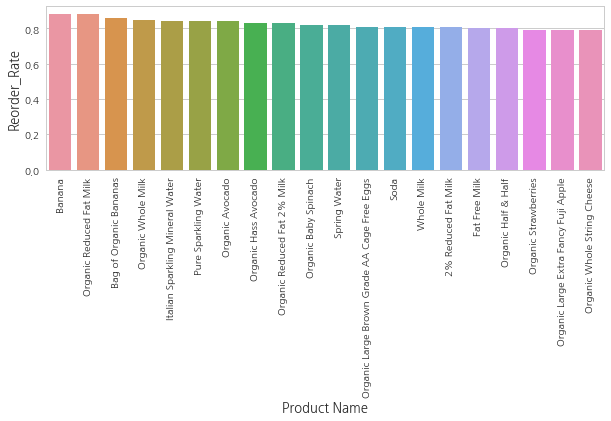

In [81]:
f, ax = plt.subplots(figsize = (10, 3))
plt.xticks(rotation = 'vertical')
sns.barplot(rankrank['product_name'], rankrank['reorder_rate'])
plt.ylabel('Reorder_Rate', fontsize = 13)
plt.xlabel('Product Name', fontsize = 13)
plt.show()

##### Insights & Followup

- 바나나, 우유, 물 등이 압도적인 Top10을 점유하고 있고, 각종 야채들 또한 높은 재구매율을 보임

#### 5. 그렇다면 어떤 Aisle이 재구매 비율이 높을까? 그리고 낮을까?

In [82]:
# product_reorder_ds.groupby('aisle_id').agg({'product_name':                                           lambda x: })
from collections import defaultdict
import operator

def popularWords(names, topn=2):
    wordFrequency = defaultdict(int)
    def updateWords(words):
        for word in words :
            if len(word)>1:
                wordFrequency[word] += 1
    names.apply(lambda x: updateWords(x.split()))
    tops = sorted(wordFrequency.items(), key=operator.itemgetter(1),reverse=True)[:topn]
    return " ".join([n[0] for n in tops])

In [83]:
aisle_ds = products.groupby('aisle_id').agg({'product_name':popularWords
                                               , 'product_id':lambda x:len(x.unique())})
# aisle_ds.columns = ['products','product_names']

In [84]:
aisle_order_stat_ds = product_reorder_ds.groupby('aisle_id').agg({'total_order':sum, 'reorder':sum})
aisle_order_stat_ds['reorder_rate'] = round(aisle_order_stat_ds.reorder / aisle_order_stat_ds.total_order, 2)
aisle_order_stat_ds = aisle_order_stat_ds.merge(aisle_ds, left_index=True, right_index=True).sort_values('reorder_rate', ascending=False)
aisle_order_stat_ds.index = aisle_order_stat_ds.product_name + "(" + aisle_order_stat_ds.index.astype(str)+")"

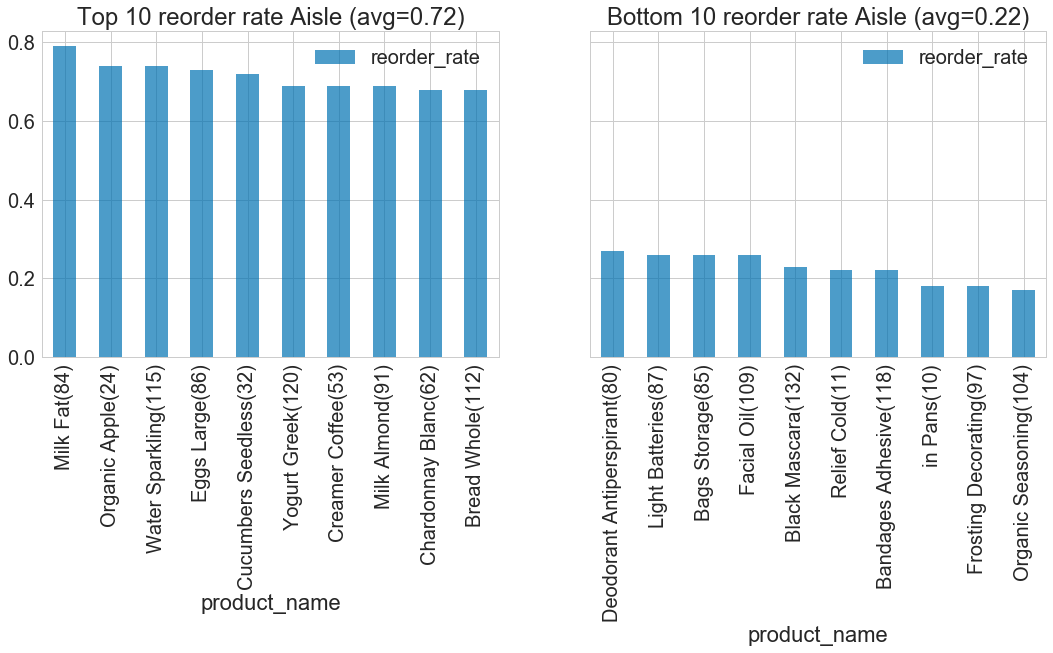

In [85]:
sns.set(style="whitegrid", palette="colorblind", font_scale=2)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

top20_ds = aisle_order_stat_ds[['reorder_rate']][:10]
top20_ds.plot(kind='bar', figsize=(16,6), alpha=.7, ax=ax1
             , title='Top 10 reorder rate Aisle (avg={})'.format(toReadable(top20_ds.reorder_rate.mean())))

bottom20_ds = aisle_order_stat_ds[['reorder_rate']][-10:]
bottom20_ds.plot(kind='bar', figsize=(18,6), alpha=.7, ax=ax2
                , title='Bottom 10 reorder rate Aisle (avg={})'.format(toReadable(bottom20_ds.reorder_rate.mean())))
plt.show()

##### Insights & Followup

- 역시나 유제품, 과일, 물, 계란, 야채, 빵등 꾸준히 먹는 식료품들은 습관적 재구매가 일어나는 경향이 확인
- 반면 생활가전, 주방용품, 장식품, 의약품, 조미료 등 간헐적, 비정기적으로 구매가 일어날만한 상품들이 Bottom 10에 대거 포진하는 모습

#### 6. 주문이 많은 상품이 재구매율이 높을까? 

1) 상품별 총 주문수량 대비 재주문비율 

2) 상품별 재주문비율 대비 총 주문수량

In [86]:
product_reorder_ds[:10]

,total_order,reorder,unique_users,reorder_rate,orders_per_user,product_id,product_name,aisle_id,department_id
0,76,49,76,0.64,1.0,1,Chocolate Sandwich Cookies,61,19
1,4,1,4,0.25,1.0,2,All-Seasons Salt,104,13
2,6,6,6,1.00,1.0,3,Robust Golden Unsweetened Oolong Tea,94,7
3,22,14,22,0.64,1.0,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,1,1,1,1.00,1.0,5,Green Chile Anytime Sauce,5,13
6,1,1,1,1.00,1.0,7,Pure Coconut Water With Orange,98,7
7,13,7,13,0.54,1.0,8,Cut Russet Potatoes Steam N' Mash,116,1
8,5,2,5,0.40,1.0,9,Light Strawberry Blueberry Yogurt,120,16
9,119,70,119,0.59,1.0,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7
10,2,1,2,0.50,1.0,11,Peach Mango Juice,31,7


In [87]:
product_reorder_ds['total_order'].max()

18726

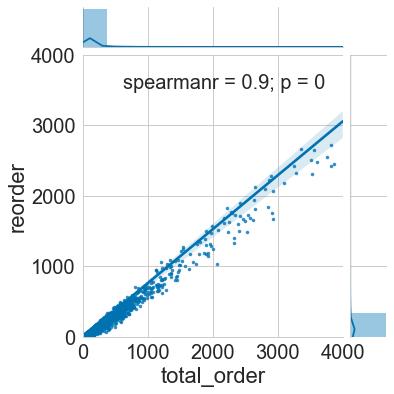

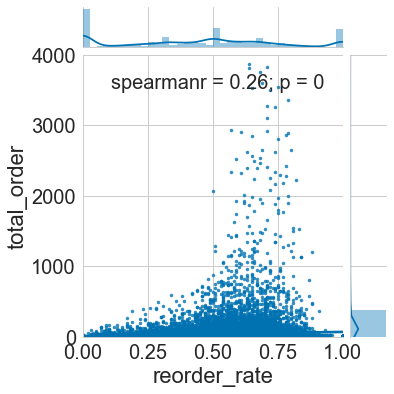

In [88]:
from scipy.stats import spearmanr
g = sns.jointplot("total_order", "reorder", kind="reg", marker='.', xlim=(0, 4000), ylim=(0,4000), size=6, ratio=6
                  , stat_func=spearmanr
                  , data=product_reorder_ds)

h = sns.jointplot("reorder_rate", "total_order", kind="reg", marker='.', xlim=(0,1), ylim=(0,4000), size=6, ratio=6
                  , stat_func=spearmanr
                  , data=product_reorder_ds)

plt.show(g, h)

##### Insights & Followup

- 총 주문량이 많은 상품은 재주문수량도 높게 나오는것을 확인 
- 재주문비율이 높은 상품들 또한 총 주문량이 대체로 높아지는 경향을 보임

## 4. Clustering

### Hierarchical Clustering (Dendrogram)

- 재구매율을 기준으로 Hierarchical Clustering 기법을 활용해 군집화
- Dendogram을 통해 시각화

In [182]:
from IPython.display import display
%matplotlib inline
plt.style.use('ggplot')

In [183]:
#Add some averages
temp = pd.merge(left=products,
         right=order_products__train.product_id.value_counts().to_frame('count'), 
         left_index=True, right_index=True)

temp = pd.merge(left=temp, 
                    right=pd.DataFrame(order_products__train.groupby('product_id').reordered.sum().to_frame(), dtype='int64'),  
                    left_index=True, right_index=True)

temp['reorder_rate'] = temp['reordered']/temp['count']

temp = pd.merge(left=temp, 
                right=order_products__train.groupby('product_id').add_to_cart_order.mean().to_frame('add_to_cart_mean'),
                left_index=True, right_index=True)

temp = pd.merge(left=temp, 
                right=pd.merge(left=order_products__train, 
                               right=orders[['order_dow', 'order_hour_of_day', 'days_since_prior_order']], 
                               left_on='order_id', right_index=True).groupby('product_id').order_dow.mean().to_frame(),
                left_index=True, right_index=True)

temp = pd.merge(left=temp, 
                right=pd.merge(left=order_products__train, 
                               right=orders[['order_dow', 'order_hour_of_day', 'days_since_prior_order']], 
                               left_on='order_id', right_index=True).groupby('product_id').order_hour_of_day.mean().to_frame(),
                left_index=True, right_index=True)

temp = pd.merge(left=temp, 
                right=pd.merge(left=order_products__train, 
                               right=orders[['order_dow', 'order_hour_of_day', 'days_since_prior_order']], 
                               left_on='order_id', right_index=True).groupby('product_id').days_since_prior_order.mean().to_frame(),
                left_index=True, right_index=True)
display(temp.head())
temp.shape

,product_id,product_name,aisle_id,department_id,count,reordered,reorder_rate,add_to_cart_mean,order_dow,order_hour_of_day,days_since_prior_order
1,2,All-Seasons Salt,104,13,76,49,0.644737,6.921053,2.868421,14.236842,11.547945
2,3,Robust Golden Unsweetened Oolong Tea,94,7,4,1,0.250000,15.750000,3.000000,13.000000,10.500000
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,6,6,1.000000,4.500000,2.833333,15.333333,7.833333
4,5,Green Chile Anytime Sauce,5,13,22,14,0.636364,8.954545,3.045455,15.045455,9.500000
5,6,Dry Nose Oil,11,11,1,1,1.000000,5.000000,4.000000,9.000000,15.000000


(39122, 11)

In [184]:
# 주문 횟수 10번 이하의 상품목록 제거

temp = temp[temp['count'] > 10]
temp.shape

(13377, 11)

In [185]:
# 상품명, Dep, Aisle, 재구매여부 컬럼 제거 
temp.drop(['product_name', 'department_id', 'aisle_id', 'reordered'], axis=1, inplace=True)

In [186]:
temp.head()

,product_id,count,reorder_rate,add_to_cart_mean,order_dow,order_hour_of_day,days_since_prior_order
1,2,76,0.644737,6.921053,2.868421,14.236842,11.547945
4,5,22,0.636364,8.954545,3.045455,15.045455,9.500000
8,9,13,0.538462,9.846154,3.000000,14.846154,7.615385
10,11,119,0.588235,8.285714,3.033613,13.815126,11.530435
12,13,13,0.461538,10.615385,3.692308,11.846154,11.800000


In [187]:
# Standard Scaler 이용하여 Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
temp_scaled = scaler.fit_transform(temp)
print('done.')

done.


In [188]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    plt.figure(figsize=(15,10))
    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

Linkage는 Ward 방법을 사용한다. Ward방법은 유클리드거리가 아닌 오차제곱합을 통해 거리를 구하는 방식으로서, 노이즈나 이상치에 덜 민감한 특징이 있음.

- 덴도그램을 통해 계층적 군집분석의 클러스터링이 진행되고 있다. 최종적으로 아래와 같은 5개의 군집으로 나뉘게 된다.
- (계층적 클러스터링은 K-Means와는 다르게 사전에 클러스터의 개수를 정하지 않는다.)

#### Robust Scaler 활용한 Scaling

- 이상치가 포함된 데이터의 중앙값과 4분위수를 활용하여 표준화

In [231]:
from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler()
temp_robust = robust_scaler.fit_transform(temp)

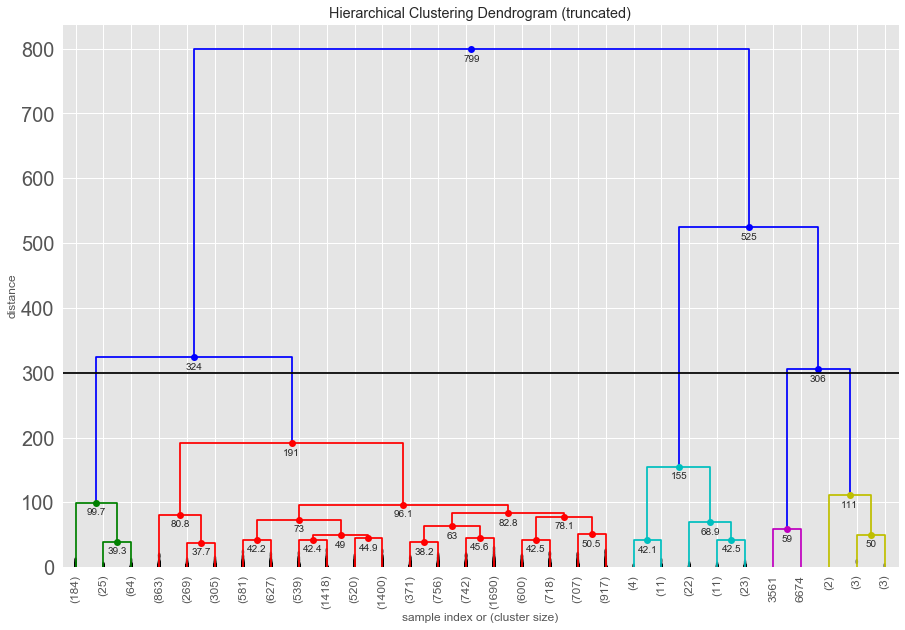

In [232]:
linked_array = ward(temp_robust)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=300
)

plt.show()

In [242]:
from scipy.cluster.hierarchy import fcluster
max_d = 300
clusters = fcluster(linked_array, max_d, criterion='distance')

labels, counts = np.unique(clusters, return_counts=True)

temp['clusters'] = clusters

print('reorder rates for each cluster\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    print('rr: {}'.format(round(temp[temp['clusters'] == i].reorder_rate.mean()*100, 2))) 

reorder rates for each cluster


label: 1
n: 273
rr: 64.4

label: 2
n: 13023
rr: 51.11

label: 3
n: 71
rr: 69.37

label: 4
n: 2
rr: 87.37

label: 5
n: 8
rr: 77.75


Robust방법은 Standard방법에 비하여 클러스터간 linkage의 거리가 확연할 뿐더러

이상치 등의 직관적인 클러스터링이 진행되어 상대적으로 의미있는 인사이트 추출

▶ 세분화된 군집을 바탕으로 변수를 추가하여 LightGBM 모델에 적용하여 더 나은 성능의 예측값을 도출

## 5. 최종 train, test dataset

In [30]:
prods = pd.DataFrame()

prods['orders'] = order_products__prior.groupby(order_products__prior.product_id).size().astype(np.int32)
prods['reorders'] = order_products__prior['reordered'].groupby(order_products__prior.product_id).sum().astype(np.float32)
prods['reorder_rate'] = (prods.reorders / prods.orders).astype(np.float32)
products = products.join(prods, on='product_id')
products.set_index('product_id', drop=False, inplace=True)

del prods

In [31]:
orders.set_index('order_id', inplace=True, drop=False)
order_products__prior = order_products__prior.join(orders, on='order_id', rsuffix='_')
order_products__prior.drop('order_id_', inplace=True, axis=1)

In [32]:
usr = pd.DataFrame()
usr['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
usr['nb_orders'] = orders.groupby('user_id').size().astype(np.int16)

In [33]:
users = pd.DataFrame()
users['total_items'] = order_products__prior.groupby('user_id').size().astype(np.int16)
users['all_products'] = order_products__prior.groupby('user_id')['product_id'].apply(set)
users['total_distinct_items'] = (users.all_products.map(len)).astype(np.int16)

users = users.join(usr)
del usr
users['average_basket'] = (users.total_items / users.nb_orders).astype(np.float32)

In [34]:
order_products__prior['user_product'] = order_products__prior.product_id + order_products__prior.user_id * 100000

In [35]:
d= dict()
for row in order_products__prior.itertuples():
    z = row.user_product
    if z not in d:
        d[z] = (1,
                (row.order_number, row.order_id),
                row.add_to_cart_order)
    else:
        d[z] = (d[z][0] + 1,
                max(d[z][1], (row.order_number, row.order_id)),
                d[z][2] + row.add_to_cart_order)


userXproduct = pd.DataFrame.from_dict(d, orient='index')
del d
userXproduct.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart']
userXproduct.nb_orders = userXproduct.nb_orders.astype(np.int16)
userXproduct.last_order_id = userXproduct.last_order_id.map(lambda x: x[1]).astype(np.int32)
userXproduct.sum_pos_in_cart = userXproduct.sum_pos_in_cart.astype(np.int16)




In [36]:
del order_products__prior

In [38]:
# train , test set 분리 

test_orders = orders[orders.eval_set == 'test']
train_orders = orders[orders.eval_set == 'train']

order_products__train.set_index(['order_id', 'product_id'], inplace=True, drop=False)

In [39]:
# feature 생성

def features(selected_orders, labels_given=False):
    
    order_list = []
    product_list = []
    labels = []
    i=0
    
    for row in selected_orders.itertuples():
        i+=1
        if i%10000 == 0: print('order row',i)
        order_id = row.order_id
        user_id = row.user_id
        user_products = users.all_products[user_id]
        product_list += user_products
        order_list += [order_id] * len(user_products)
        if labels_given:
            labels += [(order_id, product) in order_products__train.index for product in user_products]
        
    df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list
    
    # user 관련 feature
    df['user_id'] = df.order_id.map(orders.user_id)
    df['user_total_orders'] = df.user_id.map(users.nb_orders)
    df['user_total_items'] = df.user_id.map(users.total_items)
    df['total_distinct_items'] = df.user_id.map(users.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(users.average_days_between_orders)
    df['user_average_basket'] =  df.user_id.map(users.average_basket)
    
    # order 관련 feature    
    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders
    
    # product 관련 feature
    df['aisle_id'] = df.product_id.map(products.aisle_id)
    df['department_id'] = df.product_id.map(products.department_id)
    df['product_orders'] = df.product_id.map(products.orders).astype(np.int32)
    df['product_reorders'] = df.product_id.map(products.reorders)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

    # userXproduct 관련 features
    df['z'] = df.user_id * 100000 + df.product_id
    df.drop(['user_id'], axis=1, inplace=True)
    df['UP_orders'] = df.z.map(userXproduct.nb_orders)
    df['UP_orders_ratio'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_last_order_id'] = df.z.map(userXproduct.last_order_id)
    df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders).astype(np.float32)
    df['UP_reorder_rate'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number)
    df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)
  

    df.drop(['UP_last_order_id', 'z'], axis=1, inplace=True)

    return (df, labels)


In [40]:
df_train, labels = features(train_orders, labels_given=True)

f_to_use = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'aisle_id', 'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_average_pos_in_cart', 'UP_reorder_rate', 'UP_orders_since_last',
       'UP_delta_hour_vs_last'] 

order row 10000
order row 20000
order row 30000
order row 40000
order row 50000
order row 60000
order row 70000
order row 80000
order row 90000
order row 100000
order row 110000
order row 120000
order row 130000


## 6. 평가 및 예측

### LightGBM 모델 활용

In [41]:
import lightgbm as lgb

d_train = lgb.Dataset(df_train[f_to_use],
                      label=labels,
                      categorical_feature=['aisle_id', 'department_id'])  
del df_train

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss', 'auc'},
    'num_leaves': 200, # 96
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5
}
ROUNDS = 100

model = lgb.train(params, d_train, ROUNDS)

del d_train


In [42]:
# 예측, kaggle score = 0.3767675

df_test, _ = features(test_orders)

preds = model.predict(df_test[f_to_use])

df_test['pred'] = preds

TRESHOLD = 0.21  

d = dict()
for row in df_test.itertuples():
    if row.pred > TRESHOLD:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in test_orders.order_id:
    if order not in d:
        d[order] = 'None'

sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('submission.csv', index=False)


order row 10000
order row 20000
order row 30000
order row 40000
order row 50000
order row 60000
order row 70000
